Sparse matrix

In [2]:
import numpy as np
import pymc3 as pm
import scipy
import theano
import theano.tensor as tt
import matplotlib.pylab as plt

%matplotlib inline

In [6]:
d = -1
acs = [0, .1, .3]
bcs = [0, -.1, -.2]

fx = []
sx = []

for i in range(200):
    tx = [0 for i in range(4)]
    ai = np.random.randint(3)
    bi = np.random.randint(3)
    if ai > 0:
        tx[ai - 1] = 1
    if bi > 0:
        tx[bi + 1] = 1
    dr = scipy.stats.norm.cdf(d + acs[ai] + bcs[bi])
    if np.random.uniform() < dr:
        sx.append(tx)
    else:
        fx.append(tx)

In [23]:
# above just generates sparse matrix for testing
sx = np.asarray(sx)
fx = np.asarray(fx)

sxs = theano.sparse.as_sparse_variable(scipy.sparse.csr_matrix(sx))
fxs = theano.sparse.as_sparse_variable(scipy.sparse.csr_matrix(fx))

with pm.Model() as model:
    inter = pm.Normal('d', sd=20)
    bs = pm.Normal('b', sd=20, shape=(4, 1))

    fz = pm.Bound(pm.Normal, upper=0.0)('fz', mu=theano.sparse.dot(
        fxs, bs) + inter, sd=1.0, shape=(fx.shape[0], 1))
    sz = pm.Bound(pm.Normal, lower=0.0)('sz', mu=theano.sparse.dot(
        sxs, bs) + inter, sd=1.0, shape=(sx.shape[0], 1))
    # fz=pm.Bound(pm.Normal,upper=0.0)('fz',mu=theano.dot(fx,bs)+inter,sd=1.0,shape=fx.shape[0])
    # sz=pm.Bound(pm.Normal,lower=0.0)('sz',mu=theano.dot(sx,bs)+inter,sd=1.0,shape=sx.shape[0])

    trace = pm.sample(3000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sz_lowerbound__, fz_upperbound__, b, d]
100%|██████████| 3500/3500 [00:46<00:00, 75.49it/s] 
The number of effective samples is smaller than 25% for some parameters.


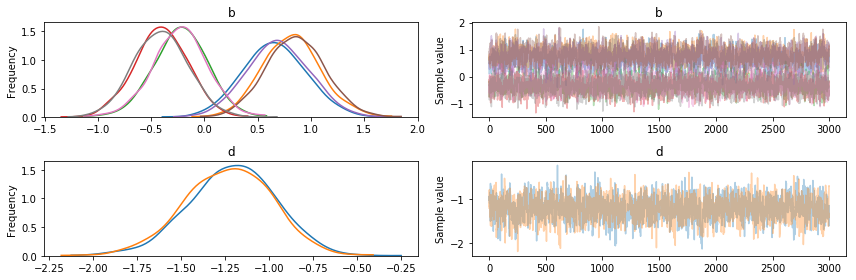

In [24]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace, varnames=['b', 'd'])
plt.tight_layout()
plt.show()